# # データ構造化ハンズオン演習　1
## 数値化・可視化編 



**対応機種** ：　 リガク　SmartLab  
**rawデータ**：　ras (テキスト形式)  
**スクリプトの内容**：  
主に粉体・薄膜用のXRD測定に用いられるリガク（SmartLab）のデータについて，データ構造化（数値csvファイル化）ならびに回折図を出力します．

![image](https://user-images.githubusercontent.com/38028745/138789951-01ea1497-be71-437d-bf6e-33c96a9aa8c2.png)


<hr>

## サンプルデータを読み込みましょう

In [1]:
!git clone https://github.com/ARIM-Japan/Training_Program_1.git
%cd Training_Program_1

Cloning into 'Training_Program_1'...
remote: Enumerating objects: 248, done.
remote: Counting objects: 100% (248/248), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 248 (delta 132), reused 97 (delta 35), pack-reused 0
Receiving objects: 100% (248/248), 409.89 KiB | 9.76 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/Training_Program_1


これで準備が整いました．

<hr>

## 1. ライブラリーを読み込みましょう
最初にコードを走らせるのに必要なライブラリーを読み込みます．ライブラリとしては以下を使っていますが，標準的なライブラリーでありますので解説はいたしません．

 * 標準ライブラリー: ``glob``, ``os``, ``csv``
 * 数値処理用: ``pandas``
 * 可視化用: ``matplotlib``  

In [2]:
# ファイル操作用
import glob
import os
import csv

# 数値処理用
import pandas as pd

# 可視化用
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter

また，出力結果を「output」フォルダーに保存するため，そのフォルダーの作成をします．

In [3]:
output_folder = 'output'
os.makedirs(output_folder,exist_ok = True)

## 2. ファイルの拡張子を調べます
データ構造化の最初のステップとして，データ構造化するファイルを特定する必要があります．その特定は**拡張子**で判定します．  
下記の``read_files``関数は入力ファイルが置いてある「data」フォルダーにある特定の拡張子のファイルをすべてリスト化します．ここでは単一のファイルではなく複数のファイルが扱えることを想定しています．

もしエラーがでたら「data」フォルダーを作成し，その中に.rasファイルを配置してみてください．

In [4]:
def read_files(extension):
    """
    概要: 特定の拡張子のついたファイルをすべて読み込む
    @param extension: 読み込む拡張子
    @return 拡張子をぬいたファイル名，　ファイル数，　出力で使うファイル名
    """

    #入力データのフォルダーを"data"とする
    path = 'data/*' + extension
    input_files = glob.glob(path)

    # 読み込みファイル数の取得
    number_of_files = len(input_files)

    # 拡張子を抜いたファイル名（出力用）
    output_name = [os.path.splitext(os.path.basename(p))[0] for p in input_files]

    return input_files, number_of_files, output_name


リガクのXRDの生ファイルである``.ras``を含むファイルを指定してみましょう．

In [5]:
default_extension = 'ras'
read_files(default_extension)

(['data/XRD_RIGAKU.ras'], 1, ['XRD_RIGAKU'])

上記のようにリスト配列の結果が戻ります．  
１つ目は「data」フォルダーにある.rasのファイル名（相対パス形式），２つ目はファイル数，３つ目は拡張子（.ras）を省いたファイル名です．  
３番目はグラフのタイトルや出力ファイル名で使うために準備します．

# 3. 特定の文字（単語）が何行目に出現するか
データ構造化では，ファイルに含まれいているヘッダー部と数値部を切り離す処理をします．その切り離す場所を判定するために特定の文字（単語）を指定する方法をとります．そのようなときに**特定の単語が現れる「行数」を判定**する関数です．

行判定は，次のような流れです．
1. ``open``関数で読みだしたファイルをtextに格納．
1. forループで一行づつtextを読み出しながら指定した文字（**word**）が含まれているかを``inキーワード``で判定
1. 一致した行をmatch_lineに格納
1. match_lineを戻し値としてreturnする

In [6]:
def get_line_number(filename,word):
    """
    概要: 特定の文字（単語）が何行目に出現するか
    @param filename: ファイル名
    @param wotd: 検索したい単語
    @return 行番号
    """
    with open(filename,  newline='') as f:
        reader = csv.reader(f)
        text = [row for row in reader]
     
    for i in range(len(text)):
        if word in text[i]:
            match_line = i
    
    return match_line

ここでは「2. ファイルの拡張子を調べます」で出力したdataフォルタにある「XRD_RIGAKU.ras」について”＊RAS_INT_START”という文字（列）が含まれる行数を調べてみることにしましょう．  

単語判定ではword = '＊RAS_INT_START'として変数としておくと，関数には読み込みやすくなります．

In [7]:
filename = "data/XRD_RIGAKU.ras"
word = '*RAS_INT_START'
get_line_number(filename,word)

469

上記のように”469”という数字が現れました．これは'RAS_INT_START'という文字列（単語）が469行目にあることを示しています．（注意：pythonは0行からカウントが始まるため，1行目カウントであれば470行目となります）  

実は，この”RAS_INT_START”はリガクの.rasファイルをみると，数値部が始まる直前の単語であることがわかります．そうです．470行目からの数値部が回折角に対する強度データとなりますので，そのための判定に使っています．

## 4. 数値化ファイル作成のための前処理
470個のヘッダーがあると，Excelでも読み込むにも使いにくい形態です．測定の設定が記録されていることでは親切ではあっても，データ処理にとっては必ずしも親切とはいえません．ヘッダーを削除した数値データのみのcsvファイルを作成しておくと使いやすくなります．  

そのための前処理として，ヘッダー部と数値部とを切り離し，数値部のみを取り出す処理を``pandas``の``read_csv``関数で行います．  

``read_csv``関数で特定の行から読み込むオプションは``header``を使います．ここでは``heaedr``は``get_line_number``関数で取得した数字を入れます．

.rasファイルの数値列は3列からなりなっていますが，3列目は不要です．ここではダミー列名として”para”としておき，それを続く``dropメソッド``を使って削除するようにしています．

In [8]:
def data_extract(file):
    """
    概要: 数値部の抽出
    @param file: npdファイル
    @return dataframe（ch,回折角，強度）
    """

    index_word = '*RAS_INT_START'
    
    start_line = get_line_number(file,index_word)

    df = pd.read_csv(file,
                 sep=' ',
                 header = start_line,
                 skip_blank_lines= False,
                 names=('2theta', 'intensity','para'))
    
    df = df.drop(['para'], axis = 1)
    df = df.dropna().astype('float')

    return df

では，XRD_RIGAKU.rasを直接指定してみましょう．dataframe形式で数値部が表示されます．

In [9]:
data = data_extract("data/XRD_RIGAKU.ras")
data

,2theta,intensity
0,25.00,13.0
1,25.01,7.0
2,25.02,12.0
3,25.03,6.0
4,25.04,3.0
...,...,...
3496,59.96,4.0
3497,59.97,2.0
3498,59.98,1.0
3499,59.99,3.0


## 5. 数値化csvファイルの保存
上記のdataとして出力したdataframeをcsv化します．ファイルの保存は``pandas``の``to_csv``関数を使います．ここでは，"output"というフォルダに"test_extract.csv"というファイル名で保存します．

その時，``index =false``とすることで行番号（インデックス番号）の出力を不要としています．

In [10]:
data.to_csv('output' + '/' + 'XRD_RIGAKU_extract.csv',index = False)

## 6. 可視化図の作成と保存
XRDの回折図のような規定パターンのグラフはユーザー関数化しておくと便利です．ここでは``make_figure``関数として作ります．第一引数にはdataframeの数値データ，第二引数は図の中で表示するタイトル名や出力ファイル名を"file"として指定します．

グラフのレイアウトの指定方法は``matplotlib``によるものです．

In [11]:
# XRDの作図
def make_figure(df, file):
    
    print ('Making plot in progress')

    # 図の設定    
    hfont = {'fontname': 'Arial'}
    fig, ax = plt.subplots(1,1, figsize=(16,9))
    
    # 可視化パラメータ
    X = df['2theta']
    Y = df['intensity']   
                
    # 可視化図
    ax.plot(X, Y,
            linewidth = 1.0, 
            color ='black')
 
    # 軸ラベル設定
    ax.set_xlabel("2theta [deg]",
                  **hfont, 
                  fontsize = 20, 
                  labelpad= 10,
                  fontweight='bold')
    
    ax.set_ylabel("Intensity [counts]",
                  **hfont, 
                  fontsize = 20, 
                  labelpad= 10,
                  fontweight='bold')

    #　軸の設定
    ax.minorticks_on()
    ax.tick_params(direction = "in", 
                   which = "both", 
                   length = 5, 
                   labelsize=16)
    
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))    
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    
    # 縦軸の指数関数型表示
    ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
        
    #ax.xaxis.offsetText.set_fontsize(16)
    ax.yaxis.offsetText.set_fontsize(16)
    
    # グリッドラインの表示
    ax.grid(which = "major", 
            axis = "both", 
            color = "gray", 
            linestyle = "--", 
            linewidth = 0.6) 
    
    # グラフタイトルの設定
    ax.set_title(file, **hfont, fontsize = 16)
    
    # 出力
    plt.savefig('output' + '/' + file + '.png', dpi=300)
    plt.show()

ここでは，第一引数として"data"とし，第二引数を＝”XRD_RIGAKU”として走らせることにしましょう．
なお，上記の最終行に``savefig``が見て取れるかと思います．ここで.pngの可視図を”output”フォルダーに保存していますのであわせて確認してみてください．

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Making plot in progress


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


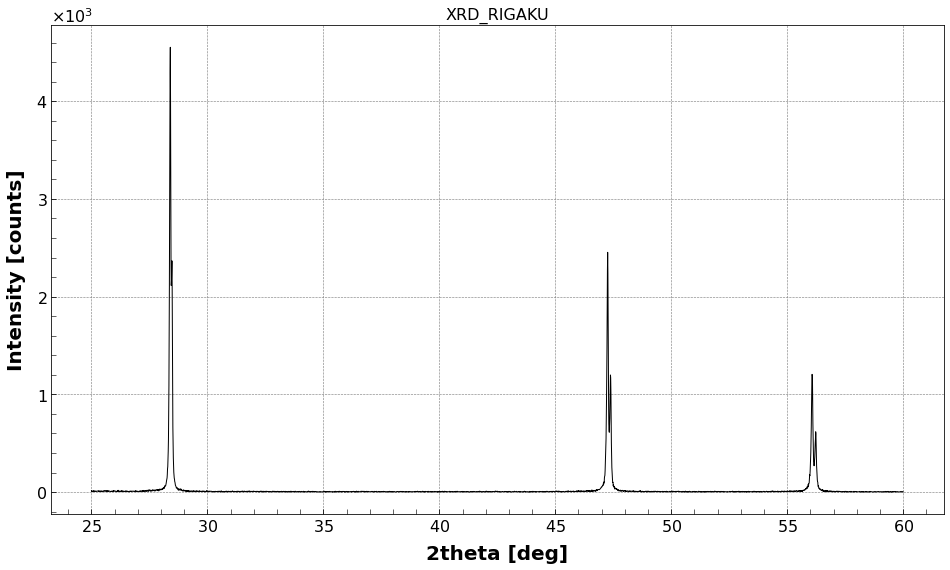

In [12]:
make_figure(data, 'XRD_RIGAKU')

## 7. 一本化する
上記の一連の処理を一本化することをします．下記のように一本化したコードを``main``関数として定義しておきます．処理の順番を並べるだけです．
また，上記ではファイルが一つだけを想定していました．下記の``main``では複数の.rasファイルがある場合にでも実行できるよう``for``ループにしています．

計測では複数ファイルを一括して処理する場合がほとんどですので，このような一連の処理は``for``ループ化しておくと作業効率化に効いてきます．

In [13]:
 def main():
    # 初期設定
    default_extension = '.ras'
    output_folder = 'output'
    os.makedirs(output_folder,exist_ok = True)
    
    # ファイルの読み込み
    [files, f_num, fname] = read_files(default_extension)
    
    # データ抽出（複数ファイルでも対応が可能）
    for i in range(f_num):

        # 数値データ部の抽出
        data = data_extract(files[i])
        
        # 数値データのcsv出力および可視化図の出力
        data.to_csv(output_folder + '/' + fname[i] + '_extract.csv',index = False)
        
        print (data)
        make_figure(data, fname[i])  

その``main``関数を下記のようにして走らせてみましょう．一連の処理が一貫で行われます．

      2theta  intensity
0      25.00       13.0
1      25.01        7.0
2      25.02       12.0
3      25.03        6.0
4      25.04        3.0
...      ...        ...
3496   59.96        4.0
3497   59.97        2.0
3498   59.98        1.0
3499   59.99        3.0
3500   60.00        2.0

[3501 rows x 2 columns]
Making plot in progress


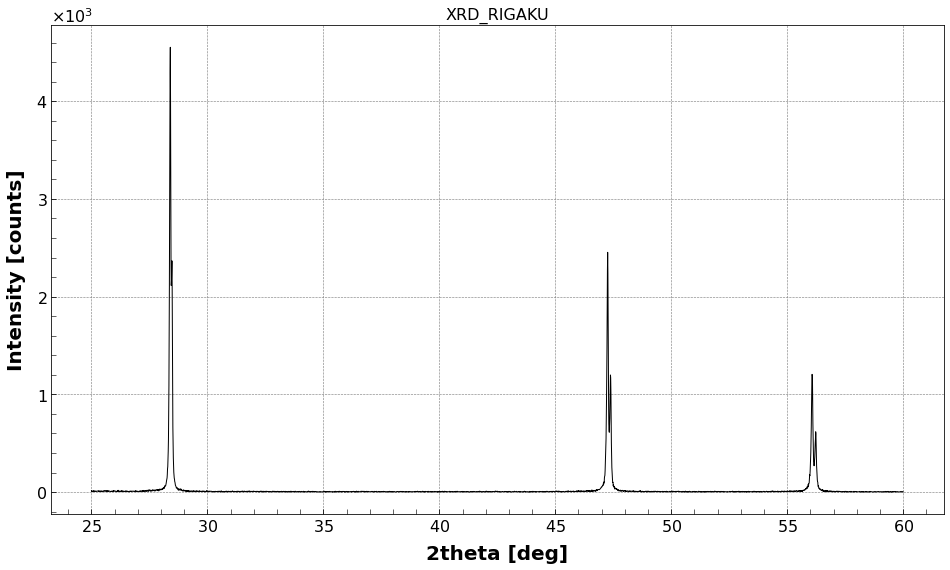

In [14]:
main()

では出力されたグラフおよびCSVを取り出して見てみましょう. PCをお使いの方々はoutput_folderというフォルダーを見れば, グラフとCSVが出力されています.
Google Colaboratoryをお使いの方々は, まず下のコマンドコードを実行してください.

In [15]:
!pwd
!ls

/content/Training_Program_1
data  output  README.md  Training_1.ipynb


現在プログラムを実行しているフォルダーがTraining_Program_1というところで, そこにdataフォルダーやoutputフォルダー, READMEやこのプログラムの書かれたノートブックのファイルであるTraining_1.ipynbもあります. では、次のコマンドコードでoutputフォルダーに移動してみましょう.

In [16]:
%cd output/
!ls

/content/Training_Program_1/output
XRD_RIGAKU_extract.csv	XRD_RIGAKU.png


XRD_RIGAKU_extract.csvというCSVファイルと, XRD_RIGAKU.pngという画像ファイルが出てきました. これを以下のプログラムコードを実行して取り出して見ましょう.

In [17]:
from google.colab import files

files.download("XRD_RIGAKU_extract.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSVファイルが無事にダウンロード出来ましたでしょうか. グラフの描かれた画像ファイルも同様にダウンロードできます.

In [18]:
files.download("XRD_RIGAKU.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## おわりに
このXRDは最も基本形のシンプルなタイプのデータ構造化の事例となります．基本的なポイントとなるのは次の処理項目です．

* データ構造化したいファイルを指定して読み込む
* 必要な数値部を抽出し保存する
* 数値部から可視化図を作成して保存する

あとは，お好みに応じて``make_figure``関数の設定を触りながらオリジナルのデザインを進めてゆくことで調整します．ここは``matplotlib``の勉強のたたき台にもなるかと思います．